Group C: Dominik A. (232487), Elena D. (232619), Benjamin A. (235194)

# Problem Set 1 - Neural network implementation

As described in section "3 Neural network implementation" of assignment 1, the goal is to build a shallow neural network from scratch using different approaches. To validate that your code is working and that the network is actually learning something, please use the following MNIST classification task. Finally, please submit proof of the learning progress as described in the assignment.

## Imports

In [5]:
import random
import pandas as pd
import numpy as np
from sklearn import model_selection
import sklearn.datasets as sk_datasets
import torchvision.datasets as torch_datasets
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

from scratch.network import Network
from scratch.res_network import ResNetwork
from pytorch.network import TorchNetwork
from scratch.utils import *

In [6]:
# Automatically load changes in imported modules
%load_ext autoreload
%autoreload 2

# Explicitly set seed for reproducibility
GLOBAL_RANDOM_STATE = 42

random.seed(GLOBAL_RANDOM_STATE)
np.random.seed(GLOBAL_RANDOM_STATE)

## A) Neural Network Classifier from Scratch

### Data

In [7]:
# Download MNIST dataset
x, y_cat = sk_datasets.fetch_openml('mnist_784', version=1, return_X_y=True, cache=True, as_frame=False)

# Preprocess dataset
x = (x / 255).astype('float32')
y_cat = y_cat.astype(int)
# One-hot encode y
y = np.zeros((len(y_cat), 10))
for i, val in enumerate(y_cat):
    y[i, val] = 1

# Use only small subset of data for faster training
x = x[:1000]
y = y[:1000]

# Split data into train and validation set
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size=0.2, random_state=GLOBAL_RANDOM_STATE)

### ML Model & Training

In [8]:
fnn = Network(sizes=[784, 128, 64, 10], learning_rate=0.1, epochs=50)
fnn.fit(x_train, y_train, x_val, y_val, cosine_annealing_lr=False)

Epoch: 1, Training Time: 0.44s, Training Accuracy: 23.62%, Validation Accuracy: 22.00%
Epoch: 2, Training Time: 0.96s, Training Accuracy: 28.75%, Validation Accuracy: 29.00%
Epoch: 3, Training Time: 1.41s, Training Accuracy: 36.00%, Validation Accuracy: 33.50%
Epoch: 4, Training Time: 1.84s, Training Accuracy: 45.25%, Validation Accuracy: 39.50%
Epoch: 5, Training Time: 2.24s, Training Accuracy: 54.00%, Validation Accuracy: 49.00%
Epoch: 6, Training Time: 2.66s, Training Accuracy: 60.00%, Validation Accuracy: 56.00%
Epoch: 7, Training Time: 3.07s, Training Accuracy: 65.75%, Validation Accuracy: 61.00%
Epoch: 8, Training Time: 3.50s, Training Accuracy: 69.12%, Validation Accuracy: 65.50%
Epoch: 9, Training Time: 3.91s, Training Accuracy: 70.75%, Validation Accuracy: 67.00%
Epoch: 10, Training Time: 4.33s, Training Accuracy: 72.25%, Validation Accuracy: 68.00%
Epoch: 11, Training Time: 4.74s, Training Accuracy: 73.62%, Validation Accuracy: 70.50%
Epoch: 12, Training Time: 5.18s, Training

### Test cosine annealing scheduler

In [9]:
cos_nn = Network(sizes=[784, 128, 64, 10], learning_rate=0.1, epochs=50)
cos_nn.fit(x_train, y_train, x_val, y_val, cosine_annealing_lr=True)

# fnn.fit(x_train, y_train, x_val, y_val, cosine_annealing_lr=True)

Epoch: 1, Training Time: 0.40s, Training Accuracy: 23.62%, Validation Accuracy: 22.00%
Epoch: 2, Training Time: 0.82s, Training Accuracy: 28.75%, Validation Accuracy: 29.00%
Epoch: 3, Training Time: 1.23s, Training Accuracy: 36.00%, Validation Accuracy: 33.50%
Epoch: 4, Training Time: 1.68s, Training Accuracy: 45.25%, Validation Accuracy: 39.50%
Epoch: 5, Training Time: 2.06s, Training Accuracy: 54.00%, Validation Accuracy: 49.00%
Epoch: 6, Training Time: 2.49s, Training Accuracy: 60.00%, Validation Accuracy: 56.00%
Epoch: 7, Training Time: 2.93s, Training Accuracy: 65.75%, Validation Accuracy: 61.00%
Epoch: 8, Training Time: 3.34s, Training Accuracy: 69.12%, Validation Accuracy: 65.50%
Epoch: 9, Training Time: 3.77s, Training Accuracy: 70.75%, Validation Accuracy: 67.00%
Epoch: 10, Training Time: 4.18s, Training Accuracy: 72.25%, Validation Accuracy: 68.00%
Epoch: 11, Training Time: 4.58s, Training Accuracy: 73.62%, Validation Accuracy: 70.50%
Epoch: 12, Training Time: 4.99s, Training

### Test residual neural network

In [10]:
res_nn = ResNetwork(sizes=[784, 128, 128, 10], learning_rate=1, epochs=50)
res_nn.fit(x_train, y_train, x_val, y_val)

Epoch: 1, Training Time: 0.73s, Training Accuracy: 78.75%, Validation Accuracy: 74.50%
Epoch: 2, Training Time: 1.48s, Training Accuracy: 90.12%, Validation Accuracy: 83.00%
Epoch: 3, Training Time: 2.20s, Training Accuracy: 93.75%, Validation Accuracy: 86.00%
Epoch: 4, Training Time: 2.91s, Training Accuracy: 95.88%, Validation Accuracy: 86.50%
Epoch: 5, Training Time: 3.64s, Training Accuracy: 97.12%, Validation Accuracy: 87.00%
Epoch: 6, Training Time: 4.39s, Training Accuracy: 97.62%, Validation Accuracy: 87.50%
Epoch: 7, Training Time: 5.18s, Training Accuracy: 98.25%, Validation Accuracy: 89.00%
Epoch: 8, Training Time: 5.92s, Training Accuracy: 98.75%, Validation Accuracy: 88.50%
Epoch: 9, Training Time: 6.63s, Training Accuracy: 99.12%, Validation Accuracy: 88.50%
Epoch: 10, Training Time: 7.34s, Training Accuracy: 99.25%, Validation Accuracy: 89.00%
Epoch: 11, Training Time: 8.05s, Training Accuracy: 99.38%, Validation Accuracy: 89.00%
Epoch: 12, Training Time: 8.76s, Training

## B) Neural Network Classifier using Torch

### Data

In [11]:
# Define data preprocessing steps
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

# Download MNIST dataset
train_set = torch_datasets.MNIST('data', train=True, download=True, transform=transform)
val_set = torch_datasets.MNIST('data', train=False, download=True, transform=transform)

# Use only small subset of data for faster training
train_set = torch.utils.data.Subset(train_set, range(1000))
val_set = torch.utils.data.Subset(val_set, range(1000))

# Utilize PyTorch DataLoader from simplified & harmonized loading of data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1)


### ML Model & Training

In [12]:
torch_nn = TorchNetwork(sizes=[784, 128, 64, 10], learning_rate=0.2, epochs=50, random_state=GLOBAL_RANDOM_STATE)
torch_nn.fit(train_loader, val_loader)

Epoch: 1, Training Time: 1.20s, Learning Rate: 0.2, Training Accuracy: 12.10%, Validation Accuracy: 10.20%
Epoch: 2, Training Time: 2.11s, Learning Rate: 0.2, Training Accuracy: 41.10%, Validation Accuracy: 38.40%
Epoch: 3, Training Time: 3.00s, Learning Rate: 0.2, Training Accuracy: 56.10%, Validation Accuracy: 52.90%
Epoch: 4, Training Time: 3.90s, Learning Rate: 0.2, Training Accuracy: 66.80%, Validation Accuracy: 61.30%
Epoch: 5, Training Time: 4.79s, Learning Rate: 0.2, Training Accuracy: 72.70%, Validation Accuracy: 66.70%
Epoch: 6, Training Time: 5.68s, Learning Rate: 0.2, Training Accuracy: 76.50%, Validation Accuracy: 68.30%
Epoch: 7, Training Time: 6.59s, Learning Rate: 0.2, Training Accuracy: 78.80%, Validation Accuracy: 69.80%
Epoch: 8, Training Time: 7.48s, Learning Rate: 0.2, Training Accuracy: 81.30%, Validation Accuracy: 70.20%
Epoch: 9, Training Time: 8.39s, Learning Rate: 0.2, Training Accuracy: 83.00%, Validation Accuracy: 72.10%
Epoch: 10, Training Time: 9.28s, Lear

## C) Visualize accuracy & hyperparameter tuning

Here, you should compare the accuracy of all trained models. Optionally, you can also show the results of hyperparameter tuning and comment which hyperparameters work best for this task.

In [13]:
# FNN
print("-"*20, "FNN", "-"*20)
fnn_train_acc = fnn.compute_accuracy(x_train, y_train)
print(f"FNN Training Accuracy: {fnn_train_acc*100:.2f}%")
fnn_acc = fnn.compute_accuracy(x_val, y_val)
print(f"FNN Validation Accuracy: {fnn_acc*100:.2f}%")

# Cosine Annealing FNN
print("-"*12, "Cosine Annealing FNN", "-"*12)
cos_train_acc = cos_nn.compute_accuracy(x_train, y_train)
print(f"Cosine Annealing FNN Training Accuracy: {cos_train_acc*100:.2f}%")
cos_acc = cos_nn.compute_accuracy(x_val, y_val)
print(f"Cosine Annealing FNN Validation Accuracy: {cos_acc*100:.2f}%")

# ResNet
print("-"*19, "ResNet", "-"*19)
resnet_train_acc = res_nn.compute_accuracy(x_train, y_train)
print(f"ResNet Training Accuracy: {resnet_train_acc*100:.2f}%")
resnet_acc = res_nn.compute_accuracy(x_val, y_val)
print(f"ResNet Validation Accuracy: {resnet_acc*100:.2f}%")


# PyTorch Network
print("-"*19, "PyTorch", "-"*19)
torch_train_acc = torch_nn.compute_accuracy(train_loader)
print(f"Torch Network Training Accuracy: {torch_train_acc*100:.2f}%")
torch_acc = torch_nn.compute_accuracy(val_loader)
print(f"Torch Network Validation Accuracy: {torch_acc*100:.2f}%")

-------------------- FNN --------------------
FNN Training Accuracy: 88.38%
FNN Validation Accuracy: 80.00%
------------ Cosine Annealing FNN ------------
Cosine Annealing FNN Training Accuracy: 88.38%
Cosine Annealing FNN Validation Accuracy: 80.00%
------------------- ResNet -------------------
ResNet Training Accuracy: 100.00%
ResNet Validation Accuracy: 89.00%
------------------- PyTorch -------------------
Torch Network Training Accuracy: 100.00%
Torch Network Validation Accuracy: 85.40%


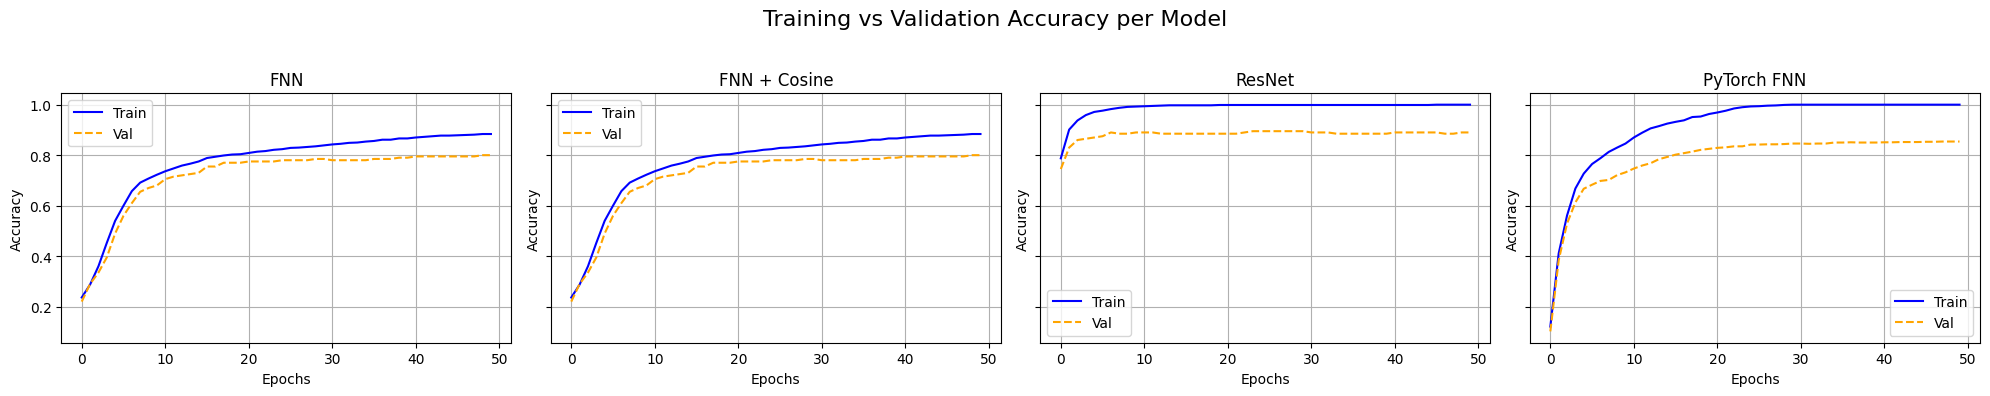

In [14]:
# List of models
models = {
    "FNN": fnn,
    "FNN + Cosine": cos_nn,
    "ResNet": res_nn,
    "PyTorch FNN": torch_nn
}

# Setup subplot grid
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4), sharey=True)

if n_models == 1:
    axes = [axes]  # make iterable

# Plot accuracies directly from model attributes
for ax, (name, model) in zip(axes, models.items()):
    ax.plot(model.train_accuracies, label="Train", color="blue")
    ax.plot(model.val_accuracies, label="Val", color="orange", linestyle="--")
    ax.set_title(name)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)

plt.suptitle("Training vs Validation Accuracy per Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
### BEGIN SOLUTION ###
 

### END SOLUTION ###

Task 1.5

In [22]:
# Define small search spaces
fnn_hiddens = [[128,64], [256,128]]
learning_rates = [0.01, 0.05]
epochs_list = [20, 50]

results = {}

# Loop over models
for hidden in fnn_hiddens:
    for lr in learning_rates:
        for ep in epochs_list:
            # --- FNN ---
            fnn = Network(sizes=[784]+hidden+[10], learning_rate=lr, epochs=ep)
            fnn.fit(x_train, y_train, x_val, y_val)
            acc = fnn.compute_accuracy(x_val, y_val)
            results[f"FNN {hidden} lr={lr} ep={ep}"] = acc
            
            # --- Cosine FNN ---
            cos_nn = Network(sizes=[784]+hidden+[10], learning_rate=lr, epochs=ep)
            cos_nn.fit(x_train, y_train, x_val, y_val, cosine_annealing_lr=True)
            acc = cos_nn.compute_accuracy(x_val, y_val)
            results[f"Cosine FNN {hidden} lr={lr} ep={ep}"] = acc
            
            # --- ResNet ---
            res_nn = ResNetwork(sizes=[784]+hidden+[10], learning_rate=lr, epochs=ep)
            res_nn.fit(x_train, y_train, x_val, y_val)
            acc = res_nn.compute_accuracy(x_val, y_val)
            results[f"ResNet {hidden} lr={lr} ep={ep}"] = acc


Epoch: 1, Training Time: 0.43s, Training Accuracy: 13.88%, Validation Accuracy: 9.50%
Epoch: 2, Training Time: 0.81s, Training Accuracy: 13.75%, Validation Accuracy: 14.50%
Epoch: 3, Training Time: 1.21s, Training Accuracy: 14.00%, Validation Accuracy: 16.00%
Epoch: 4, Training Time: 1.59s, Training Accuracy: 15.25%, Validation Accuracy: 18.50%
Epoch: 5, Training Time: 1.95s, Training Accuracy: 16.75%, Validation Accuracy: 20.00%
Epoch: 6, Training Time: 2.32s, Training Accuracy: 19.50%, Validation Accuracy: 21.50%
Epoch: 7, Training Time: 2.71s, Training Accuracy: 21.25%, Validation Accuracy: 23.50%
Epoch: 8, Training Time: 3.08s, Training Accuracy: 23.62%, Validation Accuracy: 25.00%
Epoch: 9, Training Time: 3.46s, Training Accuracy: 24.50%, Validation Accuracy: 25.50%
Epoch: 10, Training Time: 3.86s, Training Accuracy: 25.75%, Validation Accuracy: 26.50%
Epoch: 11, Training Time: 4.25s, Training Accuracy: 26.50%, Validation Accuracy: 26.50%
Epoch: 12, Training Time: 4.64s, Training 

In [25]:
batch_sizes = [1, 16]

for hidden in fnn_hiddens:
    for lr in learning_rates:
        for ep in epochs_list:
            for batch in batch_sizes:
                torch_nn = TorchNetwork(sizes=[784]+hidden+[10], learning_rate=lr, epochs=ep)
                train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch)
                val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch)
                torch_nn.fit(train_loader, val_loader)
                acc = torch_nn.compute_accuracy(val_loader)
                results[f"PyTorch {hidden} lr={lr} ep={ep} batch={batch}"] = acc


Epoch: 1, Training Time: 0.97s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 2, Training Time: 1.87s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 3, Training Time: 2.75s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 4, Training Time: 3.64s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 5, Training Time: 4.54s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 6, Training Time: 5.51s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 7, Training Time: 6.46s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 8, Training Time: 7.33s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 9, Training Time: 8.21s, Learning Rate: 0.01, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 10, Training Time: 9.09s, Lear

In [26]:
for key, acc in results.items():
    print(f"{key}: {acc*100:.2f}%")


FNN [128, 64] lr=0.01 ep=20: 36.50%
Cosine FNN [128, 64] lr=0.01 ep=20: 36.50%
ResNet [128, 64] lr=0.01 ep=20: 43.50%
FNN [128, 64] lr=0.01 ep=50: 55.50%
Cosine FNN [128, 64] lr=0.01 ep=50: 55.50%
ResNet [128, 64] lr=0.01 ep=50: 67.50%
FNN [128, 64] lr=0.05 ep=20: 68.00%
Cosine FNN [128, 64] lr=0.05 ep=20: 68.00%
ResNet [128, 64] lr=0.05 ep=20: 75.00%
FNN [128, 64] lr=0.05 ep=50: 78.00%
Cosine FNN [128, 64] lr=0.05 ep=50: 78.00%
ResNet [128, 64] lr=0.05 ep=50: 82.00%
FNN [256, 128] lr=0.01 ep=20: 44.00%
Cosine FNN [256, 128] lr=0.01 ep=20: 44.00%
ResNet [256, 128] lr=0.01 ep=20: 52.00%
FNN [256, 128] lr=0.01 ep=50: 69.50%
Cosine FNN [256, 128] lr=0.01 ep=50: 69.50%
ResNet [256, 128] lr=0.01 ep=50: 71.00%
FNN [256, 128] lr=0.05 ep=20: 71.00%
Cosine FNN [256, 128] lr=0.05 ep=20: 71.00%
ResNet [256, 128] lr=0.05 ep=20: 80.50%
FNN [256, 128] lr=0.05 ep=50: 75.50%
Cosine FNN [256, 128] lr=0.05 ep=50: 75.50%
ResNet [256, 128] lr=0.05 ep=50: 84.50%
PyTorch [128, 64] lr=0.01 ep=20 batch=1: 11.

In [27]:
best_model = max(results, key=results.get)
print(f"Best model: {best_model} with validation accuracy {results[best_model]*100:.2f}%")


Best model: ResNet [256, 128] lr=0.05 ep=50 with validation accuracy 84.50%


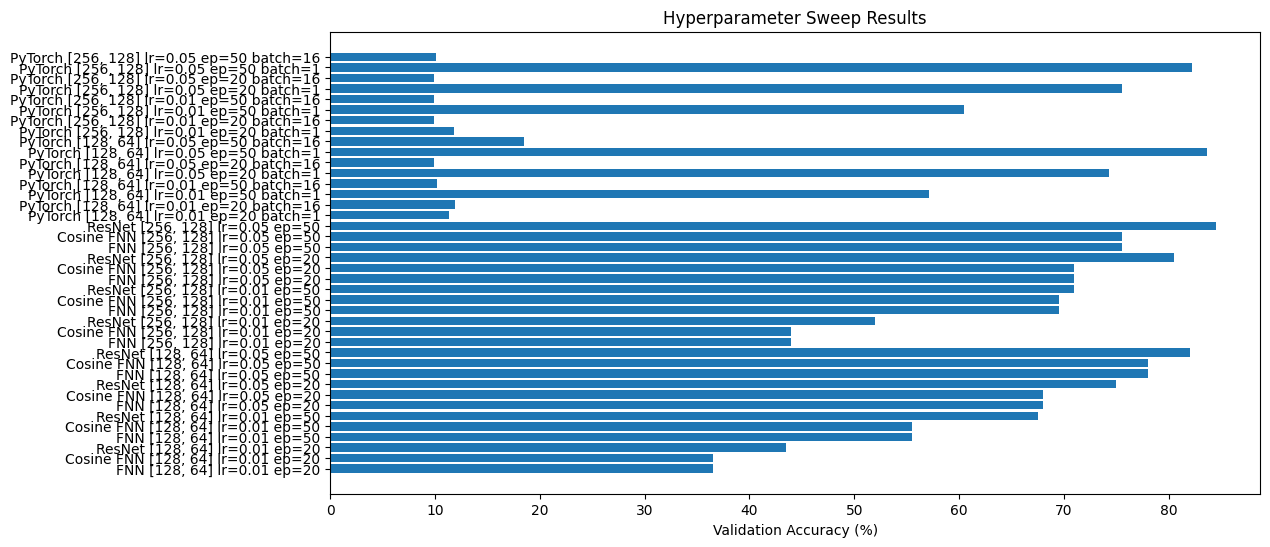

In [29]:
models = list(results.keys())
accs = [v*100 for v in results.values()]

plt.figure(figsize=(12,6))
plt.barh(models, accs)
plt.xlabel("Validation Accuracy (%)")
plt.title("Hyperparameter Sweep Results")
plt.show()


Interpretation: We ran a small hyperparameter sweep for the FNN, Cosine Annealing FNN, ResNet, and PyTorch FNN, with varying hidden layer sizes, learning rates, number of epochs, and batch size (for the pytorch model). The results showed that ResNet consistently outperformed the standard FNNs, achieving the highest validation accuracy (~84.5%), followed by the pytorch FNN with small batch size. Cosine annealing had minimal impact for these small networks. The pytorch FNN was very sensitive to batch size with larger batches leading to very poor validation performance. Validation accuracies were generally lower than in the original model runs because this sweep used smaller networks, fewer epochs for some settings, and extreme hyperparameter combinations (such as too large batch size or small learning rate), which prevented the models from fully converging. Overall, the experiments illustrate that network architecture, learning rate, training duration, and batch size all strongly influence performance, and that residual connections help improve generalization even in small networks.